In [1]:
import pandas as pd
import numpy as np
import sklearn
import os
from os.path import join

In [2]:
path = 'C:/Users/arz61/OneDrive/바탕 화면/4학년 1학기 홍혁기/오픈소스SW개론/melon chart/음성인식을통한 감정분류'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')] ## 파일명 끝이 .csv인 경우

In [3]:
file_list_py

['sample_submit.csv', 'test_data.csv', 'train_data.csv']

In [4]:
pd_sample = pd.read_csv(path + '/' +file_list_py[0])
pd_test = pd.read_csv(path + '/' +file_list_py[1])
pd_train = pd.read_csv(path + '/' +file_list_py[2])

In [5]:
pd_train

,ID,file_name,emotion
0,0,train_000.wav,disgust
1,1,train_001.wav,surprised
2,2,train_002.wav,disgust
3,3,train_003.wav,calm
4,4,train_004.wav,neutral
...,...,...,...
1003,1003,train_1003.wav,calm
1004,1004,train_1004.wav,disgust
1005,1005,train_1005.wav,calm
1006,1006,train_1006.wav,fearful


In [6]:
import librosa
import glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import librosa, librosa.display 

def load_audiofiles(file_name, sample_rate=48000):
    
    result=np.array([])
    
    audio_signal, sample_rate = librosa.load(file_name, duration=3, offset=0.5, sr=sample_rate)

    signal = np.zeros(int(sample_rate*3,))
    signal[:len(audio_signal)] = audio_signal
    
    return signal

In [7]:
from tqdm import tqdm
def load_data(data_info, isTrain=True):
    
    PATH = "C:/Users/arz61/OneDrive/바탕 화면/4학년 1학기 홍혁기/오픈소스SW개론/melon chart/음성인식을통한 감정분류"
    if isTrain:
        train_data = []#음성 feature들을 담는 dictionary
        train_label = []#학습에 사용할 label을 담는 list
        
        file_list = data_info['file_name']
        emotion_list = data_info['emotion']
        for file_name, emotion in tqdm(zip(file_list, emotion_list)):
            
            hi=join(PATH, 'train_data',file_name)
            train_data.append(load_audiofiles(hi))
            train_label.append(emotion)
            
        return np.array(train_data), np.array(train_label)
    
    else:
        test_data = []
        file_list = data_info['file_name']
    
        for file_name in tqdm(file_list):

            hi=join(PATH, 'test_data',file_name)
            test_data.append(load_audiofiles(hi))
            
        return np.array(test_data)

#DataFlair - Split the dataset
train_data, train_label = load_data(pd_train)
test_data = load_data(pd_test, isTrain=False)

1008it [03:20,  5.02it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 432/432 [01:19<00:00,  5.46it/s]


In [8]:
train_data.shape

(1008, 144000)

array([[-4.21018543e-04, -5.15965861e-04, -5.37155895e-04, ...,
        -9.78065189e-04, -6.88828528e-04, -3.30862240e-04],
       [-1.15136247e-08,  4.21569126e-08,  6.17588469e-08, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.13343837e-08,  3.70527360e-08, -3.60984380e-08, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.36580125e-08,  1.32046818e-08,  3.05960057e-08, ...,
        -3.13619967e-05, -2.56385829e-05, -1.22153560e-05],
       [ 9.28298562e-07,  1.53020142e-06,  7.74799958e-07, ...,
        -2.93038484e-05, -2.06224486e-05, -1.00194056e-05]])

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_label)
y_train = le.transform(train_label)

In [51]:
def Calculate_Melspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

mel_train = []
print("Calculate mel spectrograms for train set")
train_data = np.stack(np.array(train_data),0)
test_data = np.stack(np.array(test_data),0)
for i in range(train_data.shape[0]):
    mel_spectrogram = Calculate_Melspectrogram(train_data[i,:], sample_rate=48000)
    mel_train.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i+1,train_data.shape[0]),end='')
    
print('')
mel_train = np.stack(mel_train,axis=0)

mel_test = []
for i in range(test_data.shape[0]):
    mel_spectrogram = Calculate_Melspectrogram(test_data[i,:], sample_rate=48000)
    mel_test.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i+1,test_data.shape[0]),end='')
    
print('')
mel_test = np.stack(mel_test,axis=0)

print(f'mel_train:{mel_train.shape}, mel_test:{mel_test.shape}')

Calculate mel spectrograms for train set
 Processed 1008/1008 files
 Processed 432/432 files
mel_train:(1008, 128, 563), mel_test:(432, 128, 563)


In [57]:
mel_test[0].shape

(128, 563)

In [58]:
mel_test[0]

array([[-80.        , -75.36580791, -68.47561208, ..., -47.22450878,
        -47.62438774, -48.95785169],
       [-80.        , -75.3591427 , -68.64603193, ..., -47.45657574,
        -47.85619694, -49.14887196],
       [-80.        , -72.58519013, -69.14501489, ..., -50.19153345,
        -50.57885747, -50.27186116],
       ...,
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ],
       [-80.        , -80.        , -80.        , ..., -80.        ,
        -80.        , -80.        ]])

In [59]:
from sklearn.preprocessing import StandardScaler

x_train = np.expand_dims(mel_train, 1) #DataNum, 1ch, H, W
x_test = np.expand_dims(mel_test, 1)

scaler = StandardScaler()

b,c,h,w = x_train.shape
x_train = np.reshape(x_train, newshape=(b,-1))
x_train = scaler.fit_transform(x_train)
x_train = np.reshape(x_train, newshape=(b,c,h,w))

b,c,h,w = x_test.shape
x_test = np.reshape(x_test, newshape=(b,-1))
x_test = scaler.transform(x_test)
x_test = np.reshape(x_test, newshape=(b,c,h,w))

In [60]:
print(b,c,h,w)

432 1 128 563


In [63]:
x_test[0].shape

(1, 128, 563)

In [73]:
x_test[0]

array([[[-0.60112033, -0.30649822,  0.25706405, ...,  1.77106998,
          1.74628752,  1.63103596],
        [-0.60135263, -0.30401817,  0.24670002, ...,  1.7429967 ,
          1.71784582,  1.61426689],
        [-0.64321461, -0.08567354,  0.18801808, ...,  1.45738445,
          1.43143528,  1.40990592],
        ...,
        [-0.10187641, -0.08497671, -0.08497671, ..., -0.12079695,
         -0.10449628, -0.11001519],
        [-0.10180415, -0.08497671, -0.08497671, ..., -0.12073589,
         -0.10418719, -0.10975491],
        [-0.10175565, -0.08497671, -0.08497671, ..., -0.12069631,
         -0.10397835, -0.10958094]]])

In [12]:
import torch
import torch.nn as nn

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class ParallelModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
       
        
       # 1. 1stage (Conv + BatchNorm + ReLU + Maxpooling + Dropout)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2,padding=0),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout2d(p=0.3)
        )
                    
        
        
        
        # 2. 2stage (Conv + BatchNorm + ReLU + Maxpooling + Dropout)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4,4), stride=4,padding=0),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout2d(p=0.3)
        )
        
        
        

        # 3. 3stage (Conv + BatchNorm + ReLU + Maxpooling + Dropout)
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4,4), stride=4,padding=0),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout2d(p=0.3)
        )
        
        
        

        # 4. 4stage (Conv + BatchNorm + ReLU + Maxpooling + Dropout)
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4,4), stride=4,padding=0),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout2d(p=0.3)
        )
        
        self.fc = nn.Linear(1*4*128,8,bias=True)
        nn.init.orthogonal_(self.fc.weight)
        
        

        # Linear softmax layer
        
        

    def forward(self,x):
    ##Forward
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = output.view(output.size(0),-1)
        output = self.fc(output)
        return output
    
model = ParallelModel(num_emotions=8).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

cpu
Number of trainable params:  101736


In [13]:
!pip install livelossplot

In [14]:
EPOCHS=300
DATASET_SIZE = x_train.shape[0]
BATCH_SIZE = 64

##baseline에서 사용한 optimizer는 SGD이며 하이퍼파라미터는 다음과 같습니다.
##Learning rate = 0.01, momentum=0.9
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=1e-2, momentum=0.9)

In [15]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

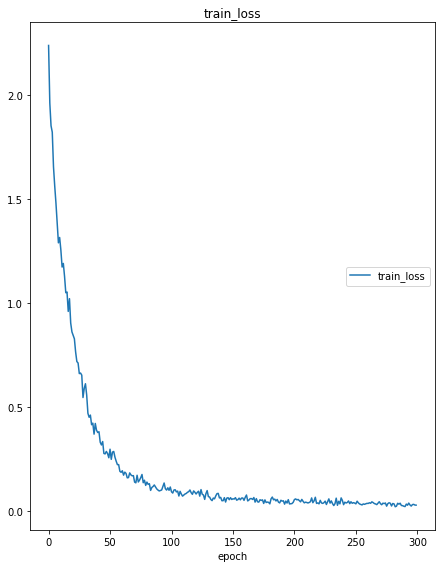

100%|█████████████████████████████████████████████████████████████████████████████| 300/300 [8:50:37<00:00, 106.13s/it]

train_loss
	train_loss       	 (min:    0.020, max:    2.239, cur:    0.028)


In [16]:
from livelossplot import PlotLosses
from tqdm import trange
liveloss = PlotLosses()

logs = {}

model.train()

for epoch in trange(EPOCHS):
    # shuffle data
    ind = np.random.permutation(DATASET_SIZE)

    x_train = x_train[ind]
    y_train = y_train[ind]
    
    epoch_loss = 0
    
    iters = int(DATASET_SIZE / BATCH_SIZE)
     
    for i in range(iters):
        ### indexing과정을 통해 작성된 Dataloader 코드
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        
        x = x_train[batch_start:batch_end]
        y = y_train[batch_start:batch_end]
        
         ###--------------------작성해야할 부분--------------------------------
        ##1.train 데이터를 torch tensor로 타입 변경 및 gpu 설정
        X = torch.FloatTensor(x).to(device)
        Y = torch.LongTensor(y).to(device)
        
        ##2.데이터를 모델의 입력으로 넣어 예측 후 loss 계산 및 optimization 
        model.train()
        hypothesis = model(X)
        loss = loss_fnc(hypothesis, Y)
        
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()
        
        ###---------------------------------------------------------------
        ##1에포크당 평균 loss를 계산하는 코드
        epoch_loss += loss.item()*actual_batch_size/DATASET_SIZE

    ###liveloss 함수를 사용하기 위한 코드들
    logs['train_loss'] = epoch_loss
        
    liveloss.update(logs)
    liveloss.draw()

In [17]:
model

ParallelModel(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.3, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2

In [18]:
path = r'C:\Users\arz61\Documents\오픈소스'
torch.save(model,os.path.join(path,'model_300.pth'))

In [71]:
model.state_dict()

OrderedDict([('layer1.0.weight',
              tensor([[[[ 0.1345, -0.0626,  0.0033],
                        [ 0.1342, -0.1919,  0.2811],
                        [ 0.0614,  0.3187,  0.2362]]],
              
              
                      [[[-0.2100, -0.0559, -0.2119],
                        [-0.0998, -0.3266, -0.2305],
                        [-0.4890, -0.3101, -0.3683]]],
              
              
                      [[[ 0.2856,  0.3243,  0.0012],
                        [-0.1010,  0.1566, -0.0276],
                        [-0.0175,  0.2382,  0.2411]]],
              
              
                      [[[ 0.4230, -0.4362,  0.1864],
                        [ 0.0084,  0.2973,  0.1936],
                        [-0.4205, -0.2736, -0.3738]]],
              
              
                      [[[ 0.2208,  0.0640,  0.1141],
                        [-0.1179,  0.4691, -0.0960],
                        [ 0.2243,  0.1708, -0.1085]]],
              
              
            

In [19]:
hypothesis

tensor([[-1.0317e+01,  6.6292e+00, -8.4358e+00, -1.6239e+00, -1.0330e+00,
          1.2890e+01,  1.4720e+00,  2.6539e-01],
        [-1.8676e-01,  1.7390e+01,  4.2369e+00, -8.2540e+00, -1.2070e+01,
          1.7365e+00,  3.3351e+00, -9.7806e+00],
        [-1.5576e+00, -1.7038e+00, -1.4101e+00, -3.9214e+00, -2.0914e+00,
         -2.1380e+00,  9.1974e+00,  1.6750e+00],
        [-4.4209e-02, -1.2661e+01, -1.1901e+01,  2.1095e+01,  5.5307e-02,
         -3.6284e+00, -2.7841e+00,  9.9973e+00],
        [-1.0713e+00,  1.5834e+01, -4.0176e+00, -5.4955e+00, -6.4604e+00,
          1.4248e+00,  9.0149e-01,  1.2632e+00],
        [ 7.0869e+00, -2.6422e+00,  1.7007e+01, -1.9197e+01, -1.5091e+00,
         -7.3502e+00,  8.6775e-01,  2.6107e+00],
        [-6.2766e-01, -4.2534e+00,  1.5326e+00, -3.6593e-01,  3.7531e-01,
         -2.6595e+00, -1.1426e+01,  1.3382e+01],
        [ 3.8789e-01, -4.6334e+00, -2.3673e+00, -3.7160e-01,  1.0157e+01,
         -3.3115e+00, -2.4138e+00,  9.2460e-01],
        [ 7.9312

In [20]:
x_test[1].shape

(1, 128, 563)

In [21]:
t = torch.Tensor(np.expand_dims(x_test[1], 0)).to(device)

In [22]:
model(t)

tensor([[-4.7910,  0.3488, -6.5197,  8.5065, -5.1568, -8.0247, 14.6517,  2.8421]],
       grad_fn=<AddmmBackward0>)

In [23]:
torch.argmax(model(t),1).cpu().detach().numpy()[0]

6

In [24]:
model.eval()

predicts = []

with torch.no_grad():
    for data in tqdm(x_test):
        ###test data를 하나씩 불러와서 학습된 모델로 추론 후 predicts array에 저장합니다.
        t = torch.Tensor(np.expand_dims(data, 0)).to(device)
        H = model(t)
        predict = torch.argmax(H, 1).cpu().detach().numpy()[0]
        predicts.append(predict)
        
print(f'predict_len:{len(predicts)}')

100%|████████████████████████████████████████████████████████████████████████████████| 432/432 [00:12<00:00, 34.66it/s]

predict_len:432


In [25]:
predicts[53]

4

In [26]:
###저장된 예측값을 위에서 사용한 label encoder를 이용해 다시 문자열로 역변환합니다.
predicts1 = le.inverse_transform(predicts)
predicts1

array(['sad', 'sad', 'calm', 'calm', 'disgust', 'sad', 'disgust', 'angry',
       'happy', 'sad', 'fearful', 'angry', 'surprised', 'surprised',
       'surprised', 'sad', 'disgust', 'calm', 'happy', 'sad', 'angry',
       'sad', 'fearful', 'neutral', 'surprised', 'sad', 'happy', 'happy',
       'happy', 'neutral', 'disgust', 'surprised', 'calm', 'sad',
       'disgust', 'happy', 'calm', 'happy', 'disgust', 'sad', 'happy',
       'disgust', 'fearful', 'angry', 'disgust', 'angry', 'neutral',
       'surprised', 'surprised', 'happy', 'happy', 'happy', 'disgust',
       'happy', 'angry', 'calm', 'angry', 'angry', 'surprised', 'calm',
       'sad', 'angry', 'surprised', 'fearful', 'sad', 'angry',
       'surprised', 'disgust', 'fearful', 'happy', 'angry', 'surprised',
       'angry', 'surprised', 'sad', 'happy', 'calm', 'happy', 'surprised',
       'happy', 'sad', 'fearful', 'disgust', 'calm', 'calm', 'angry',
       'angry', 'disgust', 'disgust', 'disgust', 'happy', 'sad', 'angry',
       

In [75]:
predicts1 = []

t = torch.Tensor(np.expand_dims(x_test[0], 0)).to(device)
H = model(t)
predict1 = torch.argmax(H, 1).cpu().detach().numpy()[0]
predicts1.append(predict)

In [76]:
predicts1

[6]

In [77]:
answer = le.inverse_transform(predicts)
answer[0]

'sad'